<a href="https://colab.research.google.com/github/Goravvv-error/Sentimental-Analysis/blob/main/Copy_of_Sentimental_Analysis_with_two_keyword_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


               Date Created  Number of Likes  \
0  2025-04-17T05:02:36.000Z                0   
1  2025-04-17T05:01:01.000Z                4   
2  2025-04-17T04:59:43.000Z                0   
3  2025-04-17T04:35:42.000Z                0   
4  2025-04-17T04:05:08.000Z                1   
5  2025-04-17T03:29:12.000Z                0   
6  2025-04-17T03:12:48.000Z                0   
7  2025-04-17T02:59:28.000Z                2   
8  2025-04-17T02:54:55.000Z                0   
9  2025-04-17T02:26:31.000Z                2   

                                               Tweet  Sentiment Score  \
0  Karnataka Caste Census : It's time for karnata...           0.0000   
1  Karnataka Caste Census is simply a Rs 160 Cror...          -0.2263   
2  Dear @socialepfo \nIts been many days since cl...           0.0000   
3  I am not going against to our parents desires....          -0.1454   
4  17% Pareshan \n\nCaste Census walo will vouch ...           0.0000   
5  Indian National Congress on X,

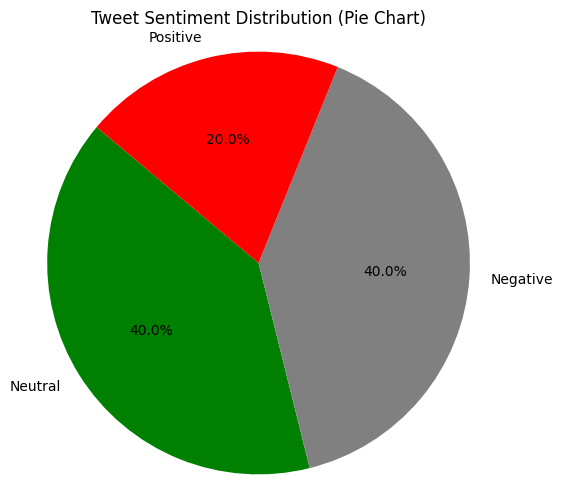

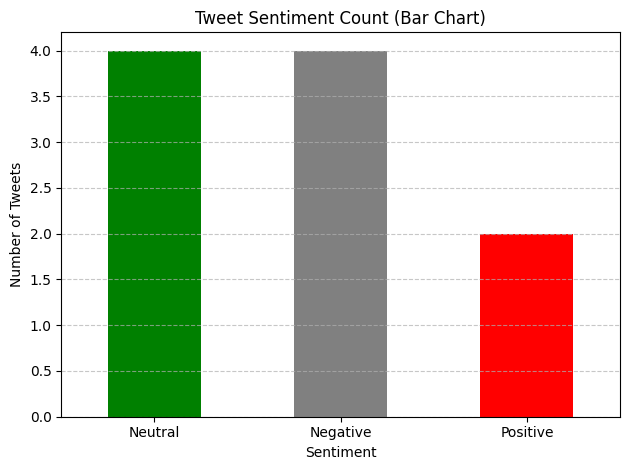

CSV saved as 'tweets_sentiment_analysis.csv'


In [ ]:
import requests
import pandas as pd
import time
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Download VADER sentiment model
nltk.download('vader_lexicon')

# Bearer Token (replace with your actual one)
bearer_token = "YOUR_BEARER_TOKEN_HERE"

# Set up authorization headers
headers = {
    "Authorization": f"Bearer {bearer_token}"
}

# Twitter recent search endpoint
search_url = "https://api.twitter.com/2/tweets/search/recent"

# Search query: tweets containing "Caste census" OR "Siddaramaiah"
query_params = {
    'query': '("Caste census" OR Siddaramaiah) -is:retweet -is:reply -has:links',
    'tweet.fields': 'created_at,public_metrics,text',
    'max_results': 10
}

# Send request to Twitter API
response = requests.get(search_url, headers=headers, params=query_params)

# Handle rate limits
if response.status_code != 200:
    if response.status_code == 429:
        print("Rate limit hit. Waiting 15 minutes...")
        time.sleep(900)
        response = requests.get(search_url, headers=headers, params=query_params)
    else:
        raise Exception(f"Request failed: {response.status_code} - {response.text}")

# Process tweets and analyze sentiment
try:
    tweets = response.json().get('data', [])
    attributes_container = [
        [tweet["created_at"], tweet["public_metrics"]["like_count"], tweet["text"]]
        for tweet in tweets
    ]

    columns = ["Date Created", "Number of Likes", "Tweet"]
    tweets_df = pd.DataFrame(attributes_container, columns=columns)

    # Sentiment analysis using VADER
    sia = SentimentIntensityAnalyzer()
    tweets_df["Sentiment Score"] = tweets_df["Tweet"].apply(lambda x: sia.polarity_scores(x)["compound"])

    def classify(score):
        if score >= 0.05:
            return "Positive"
        elif score <= -0.05:
            return "Negative"
        else:
            return "Neutral"

    tweets_df["Sentiment"] = tweets_df["Sentiment Score"].apply(classify)

    # Print results
    print(tweets_df)

    # Pie Chart
    sentiment_counts = tweets_df["Sentiment"].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
            startangle=140, colors=['green', 'gray', 'red'])
    plt.title("Tweet Sentiment Distribution (Pie Chart)")
    plt.axis('equal')
    plt.show()

    # Bar Chart
    sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
    plt.title("Tweet Sentiment Count (Bar Chart)")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Tweets")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Save to CSV
    tweets_df.to_csv("tweets_sentiment_analysis.csv", index=False)
    print("CSV saved as 'tweets_sentiment_analysis.csv'")

except KeyError as e:
    print(f"Error: Missing key in response - {e}")
    print(response.json())
